# Project 2

## Table of Contents

1. [Introduction](#chapter1)
2. [Importing functions for generating unknown data batches of Hamiltonians](#chapter2)
3. [Implementing functions for generating synthetic data](#chapter3)
4. [Implementing the neural network](#chapter4)
 1. [Creating functions to be used within the network](#section_4_1)
 * [Creating the different optimization functions](#section_4_2)
 * [Creating a function for training the neural network](#section_4_3)
 * [Testing the model for the suggested functions](#section_4_4)
 * [Testing for different variables for K, h, d and tau](#section_4_5)
 * [Testing with Adam's gradient descent](#section_4_6)
* [Testing trajectories](#chapter5)
* [Computing the gradient](#chapter6)
* [Symplectic Euler og Størmer-Verlet](#chapter7)
 1. [Testing the methods](#section_7_1)
 2. [Numerical methods for the gradient algorithm](#section_7_2)
* [Approximating the Hamiltonian for unknown trajectories](#chapter8)
* [Conclusion](#chapter9)

## Introduction <a class="anchor" id="chapter1"></a>

A neural network is a set of algorithms consisting of artificial neurons or node, and in this case supposed to be solving artificial intelligence problems. Neural networks have had a big impact on data science, and specifically machine learning. They consist of a large amount of hidden layers, where each layer has information to where each element should go next. When sending in a input layer the network will go through a series of transformations in order to approximate the most fitting result, and present it in the output layer. 


In this project we have made a model that approximates a Hamiltonian function or the energy function based on some given data points. With the help of numerical methods we are able to visualize the results. Later we will present the accuracy of the results in an symplectic Euler function and the Størmer-Verlet method.


## Importing functions for generating unknown data batches of Hamiltonians <a class="anchor" id="chapter2"></a>

In [4]:
import numpy as np
import csv
from ast import literal_eval
import re
"""
Both of the following functions import data. The output of both functions are a dictionary containing 5 arrays
    t: the array of av time points
    Q: the position values (q)
    P: the momentum values (p)
    T: the kinetic energy
    V: the potential energy
    
The data files contain data from 50 different trajectories, i.e. simulation of the path for a point with some 
initial position q0 and momentum p0. 

The function generate_data gives you the data from one of these data files, while the function concatenate
gives you the data from multiple trajectories at once. The default arguments of concatenate give you all the data
alltogether.

The folder project_2_trajectories must be placed in the same folder as your program to work. If the folder is in
some other location, the path for this location can be put into the string start_path.
"""
def generate_data(batch = 0):
    
    
    start_path = ""
    path = start_path+"project_2_trajectories/datalist_batch_" +str(batch)+".csv"
    with open(path,newline = "\n") as file:
        reader = csv.reader(file)
        datalist = list(reader)
    
    N = len(datalist)
    t_data = np.array([float(datalist[i][0]) for i in range(1,N)])
    Q1_data = [float(datalist[i][1]) for i in range(1,N)]
    Q2_data = [float(datalist[i][2]) for i in range(1,N)]
    Q3_data = [float(datalist[i][3]) for i in range(1,N)]
    P1_data = [float(datalist[i][4]) for i in range(1,N)]
    P2_data = [float(datalist[i][5]) for i in range(1,N)]
    P3_data = [float(datalist[i][6]) for i in range(1,N)]
    T_data = np.array([float(datalist[i][7]) for i in range(1,N)])
    V_data = np.array([float(datalist[i][8]) for i in range(1,N)])
                      
    Q_data = np.transpose(np.array([[Q1_data[i], Q2_data[i], Q3_data[i]] for i in range(N-1)]))
    P_data = np.transpose(np.array([[P1_data[i], P2_data[i], P3_data[i]] for i in range(N-1)]))
    
    return {"t": t_data, "Q": Q_data, "P": P_data, "T": T_data, "V": V_data}

def concatenate(batchmin=0, batchmax=50):
    dictlist = []
    for i in range(batchmin,batchmax):
        dictlist.append(generate_data(batch = i))
    Q_data = dictlist[0]["Q"]
    P_data = dictlist[0]["P"]
    T0 = dictlist[0]["T"]
    V0 = dictlist[0]["V"]
    tlist = dictlist[0]["t"]
    for j in range(batchmax-1):
        Q_data = np.hstack((Q_data, dictlist[j+1]["Q"]))
        P_data = np.hstack((P_data, dictlist[j+1]["P"]))
        T0 = np.hstack((T0, dictlist[j+1]["T"]))
        V0 = np.hstack((V0, dictlist[j+1]["V"]))
        tlist = np.hstack((tlist, dictlist[j+1]["t"]))
    return {"t": tlist, "Q": Q_data, "P": P_data, "T": T0, "V": V0}

## Implementing functions for generating synthetic data <a class="anchor" id="chapter3"></a>

Here we have constructed functions for generating data to test the neural network. These were all recommended to us in the project description, in order to debug the program and understand the model.

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

def fnc_1(I): #fnc_1(x) = 1/2x^2
    data = np.random.uniform(-2,2,I)
    return 0.5*data**2, data

def fnc_2(I): #fnc_2(x)=(1-cos(x))
    data = np.random.uniform(-np.pi/3,np.pi/3,I)
    return 1-np.cos(data),data

def fnc_3(I): #fnc_3(x)=1/2(y_1^2+y_2^2)
    data = np.random.uniform(-2,2,(2,I))
    return (0.5 * (data[1]**2 + data[0]**2)),data

def fnc_4(I): #fnc_4(x)=-1/(sqrt(y_1^2+y_2^2))
    #choosing m=6 as this worked best with the neural network
    m=6
    y = np.random.uniform(-m,m,(2,I))
    #excluding the data point (0,0)
    for i in range(I):
        while (y[0][i]==0) and (y[1][i]==0):
            y[0][i]=np.random.uniform(-m,m)
            y[1][i]=np.random.uniform(-m,m)
    return -(1/np.sqrt(y[0]**2+y[1]**2)),y

## Implementing the neural network <a class="anchor" id="chapter4"></a>

### Creating functions to be used within the network <a class="anchor" id="section_4_1"></a>

Creating the sigma and hypothesis functions and their derivative, as they will be used later in the network. Also creating the cost function, which tells us qualitatively how well-approximated our network will be.

In [6]:
#creating the sigmoid and its derivative

def sigma(x):
    return np.tanh(x)

def sigma_derived(x):
    return (1/np.cosh(x))**2

#creating the hypothesis function and its derivative

def hyp_fnc(x):
    return x

def hyp_derived(x):
    return np.ones(np.shape(x))


#we decided to go with the identity function, as we did not wish to scale down its values
#also, we felt that the use of 0.5*(1+np.tanh(x*0,5)) gave inaccurate values during the training phase.
"""
def hyp_fnc(x):
    return 0.5*(1 + np.tanh(x*0.5))
    #return x

def hyp_derived(x):
    return 0.25*(1/np.cosh(x*0.5))**2
    #return 1"""

'\ndef hyp_fnc(x):\n    return 0.5*(1 + np.tanh(x*0.5))\n    #return x\n\ndef hyp_derived(x):\n    return 0.25*(1/np.cosh(x*0.5))**2\n    #return 1'

In [7]:
#making the cost function, J(theta)

def J_theta(Y,c):
    return 0.5 * np.linalg.norm(Y-c)**2

### Creating the different optimization functions <a class="anchor" id="section_4_2"></a>

The two functions below are made to help us obtain the gradient  for a given parameter set. The first one is a basic optimization function called the plain vanilla descent, while Adams gradient descent is a better method that gave us a more fitting output.

In [8]:
#we want these to iterate within the loop
#the gradient based optimization returns mj and vj but does not use this
#this is to standardize the functions, so that one can choose which function to use through the input in the neural network.

def grad_based_opt(weight, weight_derived, tau,m0,v0,j):
    weight = weight - (tau * weight_derived)
    return weight,m0,v0

#creating adams gradient descent
def adams_method(weight,weight_derived,tau,m0,v0,j):
    beta_1=0.9
    beta_2=0.999
    alfa = 0.01
    epsilon = 1e-8
    gj = weight_derived
    mj = beta_1*m0 + (1-beta_1)*gj
    vj = beta_2*v0 + (1-beta_2)*(gj*gj)
    mj_hat = mj/(1-(beta_1**j))
    vj_hat = vj/(1-(beta_2**j))
    weight = weight - alfa*mj_hat/(epsilon + np.sqrt(vj_hat))
    m0=mj
    v0=vj
    return weight,mj,vj

### Creating a function for training the neural network <a class="anchor" id="section_4_3"></a>

Here is the algorithm for the neural network, both for training and as well as for sending values through the network with the weights obtained from training.

In [119]:
#K :amount of hidden layers
#d: dimension of the problem, needs to be equal or bigger to d0
#I: I demounts the amount of data used
#tau: setting the learning paramtre
#h: setting the step size
#d0: the input dimension
#c: the data set we wish to train our set to become
#y: the data set we wish to approximate
#optimize: the gradient optimization method, can either be gradient based optimization or adam's gradient descent





def neural_network(K,d,I,tau,h,d0,c,y,optimize = grad_based_opt):
    tolerance = 1e-2
    total_it = 10000
    it = 0
    #creating matrix Y0
    Y0 = np.zeros((d,I))
    Y0[0:d0,:]=y
    
    #creating a list of the J(thetas) to see convergence
    J_lst = np.zeros(total_it)
    
    
    #implementing the weights, k layers of dxd matrices
    W_k=np.random.rand(K,d,d)
    
    #implementing the b_k weights, k vectors of d dimension
    b_k=np.random.rand(K,d,1)
    
    #giving w and my some random value
    w=np.random.rand(d)
    my=np.random.rand(1)

    #initialising values for Z_k and P_k
    Z_k=np.zeros((K,d,I))
    Z_k[0,:,:]=Y0
    P_k = np.zeros((K,d,I))
    
    
    #setting a value for upsilon so that we can use error tolerance
    upsilon=np.ones(I)
    
    #setting initial values for m0 and v0, in case the use of Adam's gradient descent
    #they are all of different value according to the theta
    m0_wk=0
    m0_bk=0
    m0_my=0
    m0_w=0
    v0_wk=0
    v0_bk=0
    v0_my=0
    v0_w=0
    
    #starting the loop
    while (it<total_it) and J_theta(upsilon,c)>tolerance:
        it+=1
        
        #going through the layers Z_k
        for k in range (0,K-1):
            Z_k[k+1,:,:]=Z_k[k,:,:]+ h*sigma(W_k[k,:,:]@Z_k[k,:,:]+b_k[k,:])
            
            
        #upsilon is the last layer, and thus the output
        upsilon = hyp_fnc((np.transpose(Z_k[K-1,:,:])@w) + (my*np.ones(I)))
        #computing P_K
        
        P_K = np.outer(w,np.transpose((upsilon-c) * hyp_derived(np.transpose(Z_k[K-1,:,:])@w+(my*np.ones(I))))) 
        
        
        #computing derivatives of my and w
        dJ_dmy = np.transpose(hyp_derived(np.transpose(Z_k[K-1,:,:])@w + (my*np.ones(I))))@(upsilon-c)
        dJ_dw = Z_k[K-1,:,:]@((upsilon - c)*hyp_derived(np.transpose(Z_k[K-1,:,:])@w + my))
        
        #adding P_K to the last layer of P_k
        P_k[K-1,:,:]=P_K
        
        #backwards propagation
        for k in range(K-1,0,-1):
            P_k[k-1,:,:]=P_k[k,:,:] + h*np.transpose(W_k[k-1,:,:])@sigma_derived((W_k[k-1,:,:]@Z_k[k-1,:,:]+b_k[k-1,:])*P_k[k,:,:])

        #deriving Wk and bk
        for k in range(0,K-1):
            dJ_dWk = h * (P_k[k+1,:,:]*sigma_derived(W_k[k,:,:]@Z_k[k,:,:] + b_k[k,:]))@np.transpose(Z_k[k,:,:])
            dJ_dbk = h * (P_k[k+1,:,:]*sigma_derived(W_k[k,:,:]@Z_k[k,:,:] + b_k[k,:]))@np.ones(I)
            dJ_dbk = dJ_dbk[:,np.newaxis]
        
        
        #updating the weights
        for k in range(0,K-1):
            W_k[k,:,:],m0_wk,v0_wk=optimize(W_k[k,:,:],dJ_dWk,tau,m0_wk,v0_wk,it)
            b_k[k,:,:],m0_bk,v0_bk=optimize(b_k[k,:,:],dJ_dbk,tau,m0_bk,v0_bk,it)
            
        my,m0_my,v0_my = optimize(my,dJ_dmy,tau,m0_my,v0_my,it)
        w,m0_w,v0_w = optimize(w,dJ_dw,tau,m0_w,v0_w,it)
        
        #adding J(theta) to the convergence list
        J_lst[it-1]=J_theta(upsilon,c)
        
    theta=np.array([W_k,b_k,w,my])    
    return upsilon,theta,J_lst

In [10]:
#also a function for sending data points through the weights acquired by the neural network

def send_through_network(K,d,I,tau,h,d0,y,weight):
    #creating the matrix Y0
    Y0 = np.zeros((d,I))
    Y0[0:d0,:]=y
    
    Z_k=np.zeros((K,d,I))
    Z_k[0,:,:]=Y0
    
    #initializing the weights
    W_k = weight[0]
    b_k = weight[1]
    w = weight[2]
    my = weight[3]
    
    #going through the layers Z_k
    for k in range (0,K-1):
        Z_k[k+1,:,:]=Z_k[k,:,:]+ h*sigma(W_k[k,:,:]@Z_k[k,:,:]+b_k[k,:])
    #upsilon is the last layer, and thus the output
    upsilon = hyp_fnc((np.transpose(Z_k[K-1,:,:])@w) + (my*np.ones(I)))
   
    return upsilon, Z_k

    

### Testing the model for the suggested functions <a class="anchor" id="section_4_4"></a>

We tested the model with all the given functions, in order to see to what extent it worked for different dimensions. During the training phase, we trained with I = 5 000. However, we used I = 1000 during the testing phase. This was to ensure that the training phase had a high amount of data in order to make the model as "prepared" as possible.

The dimensions used were the ones recommended in the description of the project. We have tried various different values of K, h, tau and d, and through trial and error decided to portray the neural network using the hyperparameters which we believed gave a good fit.

We discovered through the training and testing phase that K and h were dependent on each other, and that some of our best results were obtained when Kh=1. For a lower amount K values we would need a higher stepsize h, as there would be a larger leap between the layers.

In [107]:
#amount of hidden layers
K=30
#dimension of the problem, needs to be equal or bigger to d0
d=2
#I demounts the amount of data used
I=5000
#setting the learning parametre
tau = 0.00010599
#setting the step size
h = 1/30
#setting the initial dimension d0
d0 = 1

#this is not the I for the training phase, but for the test phase
#we wish to test for a lower value of I as we hope it will give us more accurate results
I_try=1000

In [9]:
#testing the neural network for fnc_1:



c_fnc1,y_fnc1 = fnc_1(I)

upsilon_fnc1,weight_fnc1,Js_fnc1=neural_network(K,d,I,tau,h,d0,c_fnc1,y_fnc1)



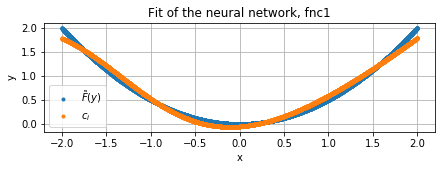

Cost function gives us for this one 12.966929173652309


In [10]:
#plotting the neural network for fnc_1 to see how well it fits

plt.figure(figsize=(7,2))
plt.title("Fit of the neural network, fnc1")
plt.ylabel("y")
plt.xlabel("x")
plt.plot(y_fnc1,c_fnc1,".",label="$\~F(y)$")
plt.plot(y_fnc1,upsilon_fnc1,".",label="$c_i$")
plt.legend()
plt.grid()
plt.show()
print("Cost function gives us for this one",J_theta(upsilon_fnc1,c_fnc1))


This model shows us the fit of the neural network for function 1. If one were to divide the cost function by the amount of data points used, one can see that the cost function would be approximately 0.0026 per data point. We thereby see that the neural network approximates function 1 quite accurately.

As one can see on the graph, the neural network approximation differs the largest from the actual function $c_i$ at the area closest to the endpoints. We have observed this for several of the other functions, and acknowledge that the neural network is bad at approximating this area. A reason for this can be that the area closest to the endpoints differs the largest from the function in general, and therefore the neural network is not able to predict this part. Another reason could be that the curvature here is steeper than for the rest of the function, with not enough data points to predict this path.

The cost function for this one gives us 2.7467316514873494


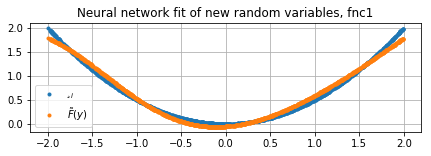

In [11]:
#generating new random variables and weights to send through the function
c_fnc1,y_fnc1 = fnc_1(I_try)

#sending through the network and plotting to see the difference
plt.figure(figsize=(7,2))
plt.title("Neural network fit of new random variables, fnc1")
ups1,Z_k1=send_through_network(K,d,I_try,tau,h,d0,y_fnc1,weight_fnc1)
plt.plot(y_fnc1,c_fnc1,".",label="$\c_i$")
plt.plot(y_fnc1,ups1,".",label="$\~F(y)$")
plt.legend()
plt.grid()
print("The cost function for this one gives us", J_theta(ups1,c_fnc1))


Here we observe a test of function 1. The random variables sent through the K layers are approximated well, with a cost function of 0.0027 per data point. We again observe that the approximation is worse close to the endpoints, which makes sense as the weights obtained from the training phase would approximate the endpoints lower than they actually are.

In [108]:
#fnc_2:

#we don't need to restate these variables as they have been stated at the beginning of the code
"""#amount of hidden layers
K=22
#dimension of the problem, needs to be equal or bigger to d0
d=2
#I demounts the amount of data used
I=1000
#setting the learning parametre
tau = 0.001
#setting the step size
h = 0.045"""


c_fnc2,y_fnc2 = fnc_2(I)

upsilon_fnc2,weight_fnc2,Js_fnc2=neural_network(K,d,I,tau,h,d0,c_fnc2,y_fnc2)



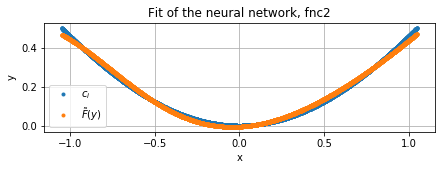

Cost function gives us for this one 0.30235053874025314


In [109]:
plt.figure(figsize=(7,2))
plt.title("Fit of the neural network, fnc2")
plt.ylabel("y")
plt.xlabel("x")
plt.plot(y_fnc2,c_fnc2,".",label="$c_i$")
plt.plot(y_fnc2,upsilon_fnc2,".",label="$\~F(y)$")
plt.legend()
plt.grid()
plt.show()
print("Cost function gives us for this one",J_theta(upsilon_fnc2,c_fnc2))



The neural network fit for function 2 fits well, with a cost function of 0.00018 per data point. We thereby see that function 2 is better approximated than function 1, however function 2 has a smaller range and has thereby less space to differ from the actual function.
We again observe that the endpoints is where the neural network approximation fails us.

Objective function gives us for this one 0.17760980784866132


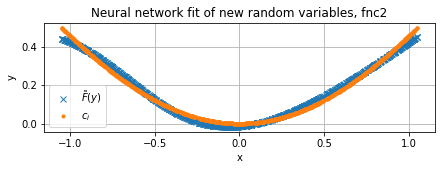

In [14]:
c_fnc2,y_fnc2=fnc_2(I_try)

ups2,Z_k2=send_through_network(K,d,I_try,tau,h,d0,y_fnc2,weight_fnc2)
plt.figure(figsize=(7,2))
plt.title("Neural network fit of new random variables, fnc2")
plt.plot(y_fnc2,ups2,"x",label="$\~F(y)$")
plt.plot(y_fnc2,c_fnc2,".",label="$c_i$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid()
print("Objective function gives us for this one",J_theta(ups2,c_fnc2))

A cost function of 0.000176 per data point shows us that the neural network approximation is a good fit for function 2.

In [110]:
#fnc_3:

"""#amount of hidden layers
K=8
#dimension of the problem, needs to be equal or bigger to d0
d=3
#I demounts the amount of data used
I=1000
#setting the learning parametre
tau = 1e-3
#setting the step size
h = 1e-2"""
#new dimension for this problem
d_4=4
d0_2=2

c_fnc3,y_fnc3 = fnc_3(I)



upsilon_fnc3,weight_fnc3,Js_fnc3=neural_network(K,d_4,I,tau,h,d0_2,c_fnc3,y_fnc3)



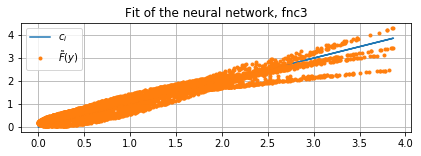

Objective function gives us for this one 156.243127718989


In [111]:
#scaling them through max-min method so that they are in the same range
#upsilon = scale_it(upsilon)
#upsilon_fnc3=scale_it(upsilon_fnc3)

plt.figure(figsize=(7,2))
plt.title("Fit of the neural network, fnc3")
plt.plot(c_fnc3,c_fnc3,label="$c_i$")
plt.plot(c_fnc3,upsilon_fnc3,".",label="$\~F(y)$")
#plt.plot(t,V,".",label="$T(p)$")
plt.legend()
plt.grid()
plt.show()

#not sure what the objective function does other than tell us of the difference between input and output
print("Objective function gives us for this one",J_theta(upsilon_fnc3,c_fnc3))

Function 3 is of a higher dimension than our previous fits of the neural network, and also worsely approximated. The cost function of 0.0602 per datapoint is not extremely high, however through the visualization of the $c_i$ points versus $\tilde{F}$ shows that $\tilde{F}$ differs greater from the calculated $c_i$ points for higher values. 

Through trial and error we have observed that the neural network badly approximates functions of higher input dimensions. This is understandable, as in a room of higher dimensions there are more aspects to take into considerations. Thereby, it is more difficult for the neural network to approximate such functions, especially when the transformation within the neural network converts all input vectors of any dimensions to dimension 1. 

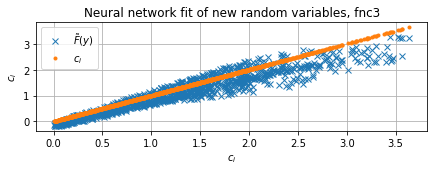

Objective function gives us for this one 52.12028594696209


In [17]:
c_fnc3,y_fnc3=fnc_3(I_try)

ups3,Z_k3=send_through_network(K,d_4,I_try,tau,h,d0_2,y_fnc3,weight_fnc3)
plt.figure(figsize=(7,2))
plt.title("Neural network fit of new random variables, fnc3")
plt.plot(c_fnc3,ups3,"x",label="$\~F(y)$")
plt.plot(c_fnc3,c_fnc3,".",label="$c_i$")
plt.xlabel("$c_i$")
plt.ylabel("$c_i$")
plt.legend()
plt.grid()
plt.show()
print("Objective function gives us for this one",J_theta(ups3,c_fnc3))

In the test phase, the values of $\tilde{F}$ also differ from the values of $c_i$ for higher values, which is reasonable as this was shown through the training phase. The cost function of 0.0512 per data point is not extremely high, but much higher than the previous functions. This is again explained through the loss of information when dealing with higher dimensions. 

In [112]:
#fnc_4:


d0_2=2

d_4=4

tau=0.000010599


c_fnc4,y_fnc4 = fnc_4(I)


upsilon_fnc4,weight_fnc4,Js_fnc4=neural_network(K,d_4,I,tau,h,d0_2,c_fnc4,y_fnc4)



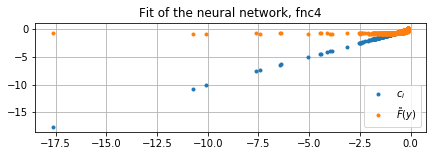

Objective function gives us for this one 410.533896434741


In [113]:
#scaling them through max-min method so that they are in the same range
#upsilon = scale_it(upsilon)

plt.figure(figsize=(7,2))
plt.title("Fit of the neural network, fnc4")
plt.plot(c_fnc4,c_fnc4,".",label="$c_i$")
plt.plot(c_fnc4,upsilon_fnc4,".",label="$\~F(y)$")
plt.legend()
plt.grid()
plt.show()


#not sure what the objective function does other than tell us of the difference between input and output
print("Objective function gives us for this one",J_theta(upsilon_fnc4,c_fnc4))

The fourth function was the one we had the most difficulties with during the testing and training phase, and found out that $\tau$ had to be lower for this function than the rest in order for it to work. With a cost function of 0.052 per data point the function is well enough approximated. However, it is shown here that points far away from origo are badly approximated.

Objective function gives us for this one 23.70215603874322


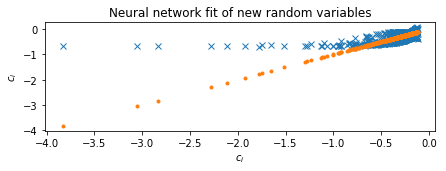

In [20]:
c_fnc4,y_fnc4=fnc_4(I_try)

ups4,Z_k4=send_through_network(K,d_4,I_try,tau,h,d0_2,y_fnc4,weight_fnc4)
plt.figure(figsize=(7,2))
plt.title("Neural network fit of new random variables, fnc4")
plt.plot(c_fnc4,ups4,"x",label="$\~F(y)$")
plt.plot(c_fnc4,c_fnc4,".",label="$c_i$")
plt.xlabel("$c_i$")
plt.ylabel("$c_i$")
print("Objective function gives us for this one",J_theta(ups4,c_fnc4))

Through testing the neural network with random variables, we see again that the values around the origo are well fitted, however those further away differ widely from the actual values and are very badly approximated.

### Testing for different variables for K, h, d and tau <a class="anchor" id="section_4_5"></a>

We decided to check which variables of K, h, d and $\tau$ were most viable for the neural network, and decided to do this through grid testing. Although the operation was a lengthy one, we deemed this to be the most correct form for testing the hyperparameters in the case of them being dependent of one another. Through grid testing, we aimed to see which values of K, h, d and $\tau$ gave the lowest cost function J($\theta$).

As we had already observed that K and h should always have an inverse relationship, we only needed to grid test values of K, d and $\tau$. We thereby tested 6 values of every hyperparameter, and created 6 (6,6) matrices where each matrix amounted to a different dimension d, every row amounted to a different K amount of layers, and every column amounted to a different value for the learning parametre $\tau$.

As the learning process neural network is in parts random due to both the initial weights bas well as the synthetic data points being random, each run gives a slightly different result. Therefore, we did the grid testing three times and took the average in order for our values to be reliable. 

In [302]:
#we wish to use grid testing
#this means that we vary d, K and tau, and look at the different combinations

#testing different values
ds = np.linspace(2,7,6,dtype=int)

Ks=np.linspace(5,30,6,dtype=int)
hs=1/K

taus = np.linspace(0.0001,0.005,6)

I=200 #so that the computation time will not take too long

d0=1 #will use function 1 as we know it is a reliable function

In [123]:
#makes a matrix that has all the different values


J_mat = np.zeros((np.shape(ds)[0],np.shape(Ks)[0],np.shape(taus)[0]))

#in order to keep track of the indices
p=0
q=0
r=0

#the process is semi-random so i want to do it three times for every value in order to make sure that it is slightly correct
for i in range(3):
    for d in ds:
        for k in Ks:
            h=1/k
            for t in taus:
                c_fnc1,y_fnc1 = fnc_1(I)
                upsilon_fnc1,weight_fnc1,Js_fnc1=neural_network(k,d,I,t,h,d0,c_fnc1,y_fnc1)
                
                print("d:",ds,"K:",k,"h:",h,"tau:",t,"J(theta):",J_theta(upsilon_fnc1,c_fnc1))
                J_mat[p,q,r]+=J_theta(upsilon_fnc1,c_fnc1)
                
                
                r+=1
            r=0
            q+=1
        q=0
        p+=1
    p=0


d: 2 K: 5 h: 0.2 tau: 0.0001 J(theta): 2.6011203913620853
d: 2 K: 5 h: 0.2 tau: 0.00108 J(theta): 0.8765136984515427
d: 2 K: 5 h: 0.2 tau: 0.0020599999999999998 J(theta): 0.6612858529643043
d: 2 K: 5 h: 0.2 tau: 0.0030399999999999997 J(theta): 13.850884008928677
d: 2 K: 5 h: 0.2 tau: 0.00402 J(theta): 3.43487054418876
d: 2 K: 5 h: 0.2 tau: 0.005 J(theta): 2.4390236270921237
d: 2 K: 10 h: 0.1 tau: 0.0001 J(theta): 2.4785224457982125
d: 2 K: 10 h: 0.1 tau: 0.00108 J(theta): 0.6973725995784756
d: 2 K: 10 h: 0.1 tau: 0.0020599999999999998 J(theta): 0.8837777611392569
d: 2 K: 10 h: 0.1 tau: 0.0030399999999999997 J(theta): 0.3965304480612566
d: 2 K: 10 h: 0.1 tau: 0.00402 J(theta): 2.982969743174182


C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in cosh
  import sys


d: 2 K: 10 h: 0.1 tau: 0.005 J(theta): 0.17397896973413735
d: 2 K: 15 h: 0.06666666666666667 tau: 0.0001 J(theta): 1.7925078377649575
d: 2 K: 15 h: 0.06666666666666667 tau: 0.00108 J(theta): 0.5118066930061431
d: 2 K: 15 h: 0.06666666666666667 tau: 0.0020599999999999998 J(theta): 2.4790062745527863
d: 2 K: 15 h: 0.06666666666666667 tau: 0.0030399999999999997 J(theta): 0.28611783649400774
d: 2 K: 15 h: 0.06666666666666667 tau: 0.00402 J(theta): 0.049778986071780336
d: 2 K: 15 h: 0.06666666666666667 tau: 0.005 J(theta): 0.02063041721645279
d: 2 K: 20 h: 0.05 tau: 0.0001 J(theta): 3.1554864975545165
d: 2 K: 20 h: 0.05 tau: 0.00108 J(theta): 4.060164716915912
d: 2 K: 20 h: 0.05 tau: 0.0020599999999999998 J(theta): 2.207002024558824
d: 2 K: 20 h: 0.05 tau: 0.0030399999999999997 J(theta): 0.5294141612818767
d: 2 K: 20 h: 0.05 tau: 0.00402 J(theta): 0.7215666626700686
d: 2 K: 20 h: 0.05 tau: 0.005 J(theta): 7.19799120213712
d: 2 K: 25 h: 0.04 tau: 0.0001 J(theta): 2.220896849191191
d: 2 K: 25

C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: overflow encountered in multiply
C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in multiply
C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:91: RuntimeWarning: invalid value encountered in multiply


d: 4 K: 25 h: 0.04 tau: 0.00402 J(theta): nan
d: 4 K: 25 h: 0.04 tau: 0.005 J(theta): 2.4892396779812804
d: 4 K: 30 h: 0.03333333333333333 tau: 0.0001 J(theta): 2.3603416354392586
d: 4 K: 30 h: 0.03333333333333333 tau: 0.00108 J(theta): 1.6391334581730508
d: 4 K: 30 h: 0.03333333333333333 tau: 0.0020599999999999998 J(theta): 0.07161058822386765
d: 4 K: 30 h: 0.03333333333333333 tau: 0.0030399999999999997 J(theta): 0.16291043290018387
d: 4 K: 30 h: 0.03333333333333333 tau: 0.00402 J(theta): 0.05992219369547727
d: 4 K: 30 h: 0.03333333333333333 tau: 0.005 J(theta): 4.775790169681221
d: 5 K: 5 h: 0.2 tau: 0.0001 J(theta): 1.468794342513974
d: 5 K: 5 h: 0.2 tau: 0.00108 J(theta): 0.10919190562280276
d: 5 K: 5 h: 0.2 tau: 0.0020599999999999998 J(theta): 0.029258943301573453
d: 5 K: 5 h: 0.2 tau: 0.0030399999999999997 J(theta): 0.0226418356733232
d: 5 K: 5 h: 0.2 tau: 0.00402 J(theta): 0.03150240272777607
d: 5 K: 5 h: 0.2 tau: 0.005 J(theta): 1.8080537563591004
d: 5 K: 10 h: 0.1 tau: 0.0001 

The above table shows what J($\theta$) value one obtains after training the neural network for the different values. The data generated is visualized below.

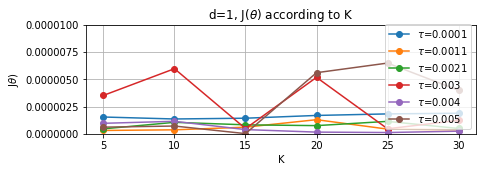

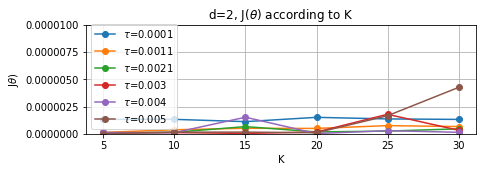

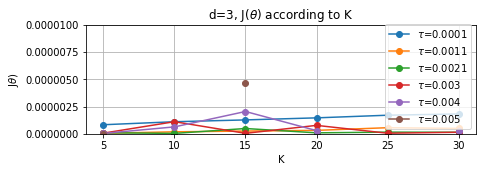

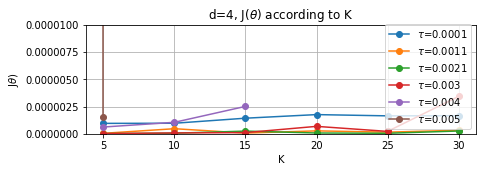

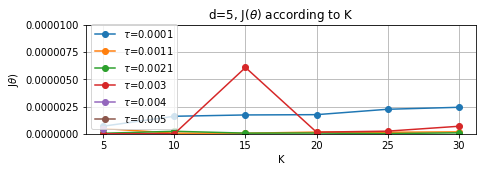

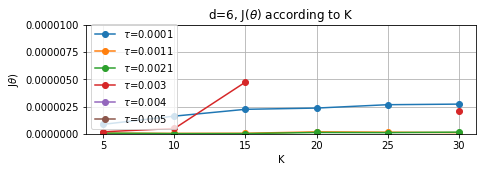

In [305]:
for i in range(6):
    plt.figure(figsize=(7,2))
    for j in range(6):
        plt.plot(Ks,J_mat[i,:,j],"-o",label=r'$\tau$'+"="+str(round(taus[j],4)))
    plt.title("d="+str(i+1)+ ", J("+str((r'$\theta$'")"))+" according to K")
    plt.xlabel("K")
    plt.ylabel("J"+str((r'$\theta$'")")))
    plt.ylim(0,1e-5)
    plt.grid()
    plt.legend()
    plt.show()

In order to get a better comparison of the different graphs in order to see which value for $\tau$ is most viable, we made a plot below with the average cost function for all the different dimensions in one plot. This is due to the difference between the scale of the various dimensions not being that large.

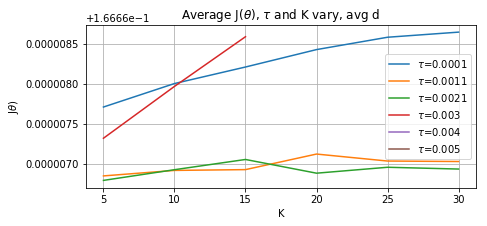

In [311]:
#best behaves when tau is 0.0011 and 0.0021 
#would therefore like to qualitatively add all the pieces together

new_mat =J_mat[:,:,1:3]
new_new_mat=new_mat[:,:,0]+new_mat[:,:,1]
newy=np.ones((1,6,6))
for i in range(6):
    newy+=J_mat[i,:,:]
newy=newy/6

plt.figure(figsize=(7,3))
for i in range(6):
    plt.plot(Ks,newy[0,:,i],label=r'$\tau$'+"="+str(round(taus[i],4)))
    plt.legend()
plt.title("Average J("+str(r'$\theta$')+"), "+str(r'$\tau$')+" and K vary, avg d")
plt.xlabel("K")
plt.ylabel("J"+str((r'$\theta$'")")))
plt.grid()
plt.show()

As one can see in the above graph, $\tau$s of a higher value often diverge, and in some cases give "nan" for the neural network. Therefore, it is viable to keep the learning parametre as low as possible. Especially the values of $\tau$=0.0011 and $\tau$=0.0021 have proven to give good values when used in the training phase of the neural network. Furthermore, for higher values of K the cost function didn't particularly change, so we noted that it is possible to keep K low and rather decrease computation time.

We also wished to see whether there was a noticeable difference between the different values of d, and have therefore displayed below the variation of J($\theta$) according to K with various d's, for a fixed $\tau$.

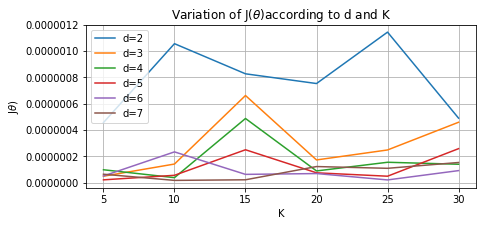

In [312]:
plt.figure(figsize=(7,3))
for i in range (6):
    plt.plot(Ks,J_mat[i,:,2],label="d="+str(ds[i]))
plt.legend()
plt.title("Variation of J("+str((r'$\theta$'")"))+"according to d and K")
plt.grid()
plt.ylabel("J"+str((r'$\theta$'")")))
plt.xlabel("K")
plt.show()

It is obvious that for higher dimensions, the cost function will be lower. We thereby set the below hyperparametres:

In [114]:
#setting values according to what we've learnt

K = 25
h = 1/K
d = 6
tau = 0.001059
I = 1000


### Testing with Adam's gradient descent <a class="anchor" id="section_4_6"></a>

When using the plain vanilla descent as an optimization function for the neural network, we didn't receive good approximations for higher dimensions. In the project booklet we were recommended Adam's gradient descent, and decided to utilize it in order to see which optimization method was the most viable. We thereby trained the neural network with both Adam's gradient descent and the plain vanilla descent for all functions, and plotted the convergence of J($\theta$) for the two methods against each other to see which one gave the best results. Ultimately, Adam's gradient descent handled higher dimensions much better as well as converged quicker, and was therefore the gradient optimization method we decided to use further on in the project.


In [355]:
#fnc_1:

c_fnc1,y_fnc1 = fnc_1(I)

upsilon_fnc1,weight_fnc1,Js_fnc1=neural_network(K,d,I,tau,h,d0,c_fnc1,y_fnc1)

ADupsilon_fnc1,ADweight_fnc1,ADJs_fnc1=neural_network(K,d,I,tau,h,d0,c_fnc1,y_fnc1,adams_method)

#upsilon_fnc2 = rescale_it(upsilon_fnc2,a2,b2)

C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in cosh
  import sys


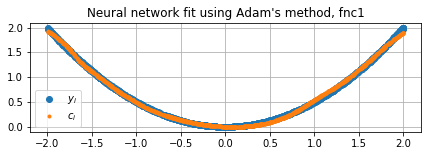

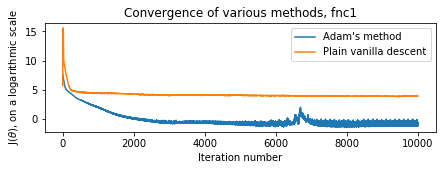

Objective function gives us for this one 0.3230500997312471


In [356]:
#scaling them through max-min method so that they are in the same range
#upsilon_fnc1 = scale_it(upsilon_fnc1)
plt.figure(figsize=(7,2))
plt.title("Neural network fit using Adam's method, fnc1")
plt.plot(y_fnc1,c_fnc1,"o",label="$y_i$")
plt.plot(y_fnc1,ADupsilon_fnc1,".",label="$c_i$")
#plt.plot(t,V,".",label="$T(p)$")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7,2))
plt.title("Convergence of various methods, fnc1")
plt.plot(np.linspace(1,10000,10000),np.log(ADJs_fnc1),label="Adam's method")
plt.plot(np.linspace(1,10000,10000),np.log(Js_fnc1),label="Plain vanilla descent")
plt.xlabel("Iteration number")
plt.ylabel("J("+str(r'$\theta$')+"), on a logarithmic scale")
plt.legend()
plt.show()


#not sure what the objective function does other than tell us of the difference between input and output
print("Objective function gives us for this one",J_theta(ADupsilon_fnc1,c_fnc1))

We thereby see that the Adam's method is much better than the gradient based optimization scheme, for higher dimensions. This tells us to rather use Adam's method for the different approximation and simulations. As we see, the Adam gradient descent oscillates when increasing the iteration number. This is due to areas with high curvature, and especially if the momentum behaves like a damped harmonic oscillator.

We notice here that by using Adam's gradient descent we avoid the problem of the endpoints not fitting properly in the neural network approximation. It seems as if this optimization technique is better at following the model's path.

In [128]:
#fnc_2:

d=2

c_fnc2,y_fnc2=fnc_2(I)

upsilon_fnc2,weight_fnc2,Js_fnc2=neural_network(K,d,I,tau,h,d0,c_fnc2,y_fnc2)

ADupsilon_fnc2,ADweight_fnc2,ADJs_fnc2=neural_network(K,d,I,tau,h,d0,c_fnc2,y_fnc2,adams_method)


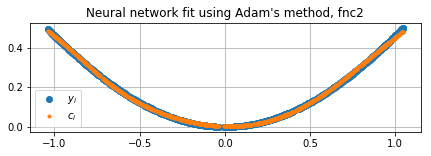

C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


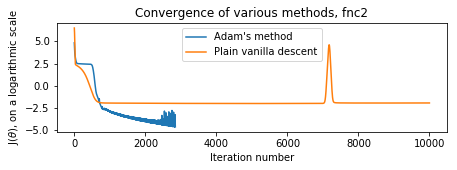

Objective function gives us for this one 0.009965705729596241


In [129]:
plt.figure(figsize=(7,2))
plt.title("Neural network fit using Adam's method, fnc2")
plt.plot(y_fnc2,c_fnc2,"o",label="$y_i$")
plt.plot(y_fnc2,ADupsilon_fnc2,".",label="$c_i$")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7,2))
plt.title("Convergence of various methods, fnc2")
plt.plot(np.linspace(1,10000,10000),np.log(ADJs_fnc2[0:10000]),label="Adam's method")
plt.plot(np.linspace(1,10000,10000),np.log(Js_fnc2[0:10000]),label="Plain vanilla descent")
plt.xlabel("Iteration number")
plt.ylabel("J("+str(r'$\theta$')+"), on a logarithmic scale")
plt.legend()
plt.show()


#not sure what the objective function does other than tell us of the difference between input and output
print("Objective function gives us for this one",J_theta(ADupsilon_fnc2,c_fnc2))

The objective function here is extremely low, and we can also see through the convergence plot that Adam's gradient descent stopped after approximately 3000 iterations due to being below the tolerance. Therefore, we see that the computation time was lower in this case whilst using Adam's gradient descent.

In [359]:


c_fnc3,y_fnc3=fnc_3(I)

d=4


upsilon_fnc3,weight_fnc3,Js_fnc3=neural_network(K,d,I,tau,h,d0_2,c_fnc3,y_fnc3)

ADupsilon_fnc3,ADweight_fnc3,ADJs_fnc3=neural_network(K,d,I,tau,h,d0_2,c_fnc3,y_fnc3,adams_method)


C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in cosh
  import sys


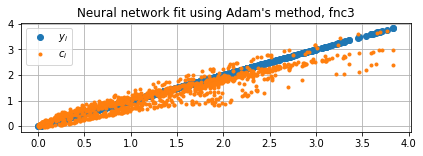

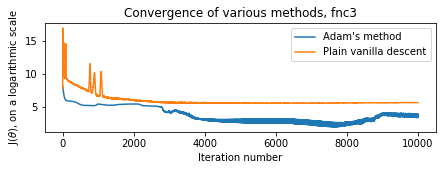

Objective function gives us for this one 53.16400262134627


In [360]:
plt.figure(figsize=(7,2))
plt.title("Neural network fit using Adam's method, fnc3")
plt.plot(c_fnc3,c_fnc3,"o",label="$y_i$")
plt.plot(c_fnc3,ADupsilon_fnc3,".",label="$c_i$")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7,2))
plt.title("Convergence of various methods, fnc3")
plt.plot(np.linspace(1,10000,10000),np.log(ADJs_fnc3),label="Adam's method")
plt.plot(np.linspace(1,10000,10000),np.log(Js_fnc3),label="Plain vanilla descent")
plt.xlabel("Iteration number")
plt.ylabel("J("+str(r'$\theta$')+"), on a logarithmic scale")
plt.legend()
plt.show()


#not sure what the objective function does other than tell us of the difference between input and output
print("Objective function gives us for this one",J_theta(ADupsilon_fnc3,c_fnc3))

Adam's gradient descent for function 3 converged quicker than Plain vanilla descent, and as shown in the convergence plot the cost function for Adam's gradient descent was constantly lower. We however encounter the same problem as with the plain vanilla descent for the values of function 3, where the data points of higher values differ more from the function.

In [122]:

c_fnc4,y_fnc4=fnc_4(I)

d=6
d0_2=2


upsilon_fnc4,weight_fnc4,Js_fnc4=neural_network(K,d,I,tau,h,d0_2,c_fnc4,y_fnc4)

ADupsilon_fnc4,ADweight_fnc4,ADJs_fnc4=neural_network(K,d,I,tau,h,d0_2,c_fnc4,y_fnc4,adams_method)


C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in cosh
  import sys
C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in multiply
C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in multiply
C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in multiply


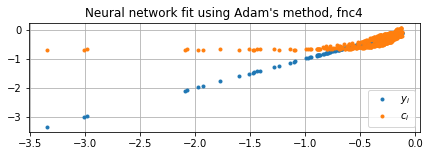

C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


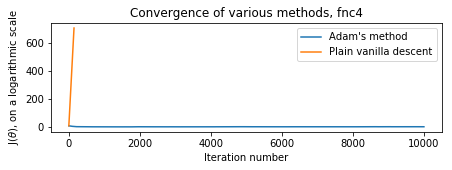

Objective function gives us for this one 20.219968953836183


In [123]:
plt.figure(figsize=(7,2))
plt.title("Neural network fit using Adam's method, fnc4")
plt.plot(c_fnc4,c_fnc4,".",label="$y_i$")
plt.plot(c_fnc4,ADupsilon_fnc4,".",label="$c_i$")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7,2))
plt.title("Convergence of various methods, fnc4")
plt.plot(np.linspace(1,10000,10000),np.log(ADJs_fnc4),label="Adam's method")
plt.plot(np.linspace(1,10000,10000),np.log(Js_fnc4),label="Plain vanilla descent")
plt.xlabel("Iteration number")
plt.ylabel("J("+str(r'$\theta$')+"), on a logarithmic scale")
plt.legend()
plt.show()


#not sure what the objective function does other than tell us of the difference between input and output
print("Objective function gives us for this one",J_theta(ADupsilon_fnc4,c_fnc4))

For function 4, we see that plain vanilla descent does not converge at all for our values. This has been a problem for this particular function throughout the training process. Adam's gradient descent, however, is able to approximate function 4 quite well, with the exception of points that stray far away from origo.

## Testing trajectories <a class="anchor" id="chapter5"></a>

As we have figured out from all the testing above, our network worked best for higher dimentions and a small $\tau$. Therefore we continue to use these values onwards. 

For the training data we decided to use every 10th element in 50 batches, so we would have many different values for energy functions. After obtaining the weights from the neural network, we tested with a new random trajectory and compared the values of T and V to our neural network approximation of them.

In [58]:
training_data = concatenate(0, 50)
t = training_data['t'][::10]
q = training_data['Q'][:,::10]
p = training_data['P'][:,::10]
T = training_data['T'][::10]
V = training_data['V'][::10]

I=np.shape(q)[1]
d0=np.shape(q)[0]
K=30
d=6
h=1/30
tau=0.001059


upsT,weight_T,JlistT = neural_network(K,d,I,tau,h,d0,T,p,adams_method)


upsV,weight_V,JlistV = neural_network(K,d,I,tau,h,d0,V,q,adams_method)


C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in cosh
  import sys
C:\Users\lefti\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in cosh
  import sys


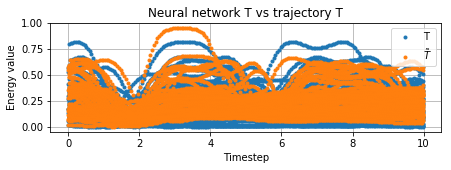

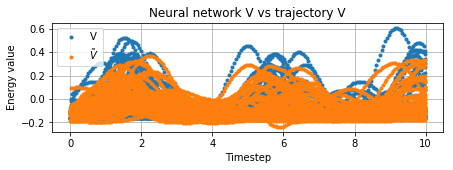

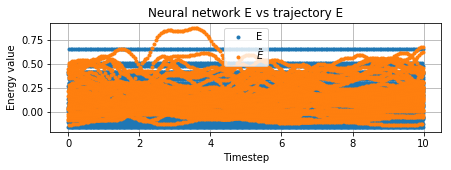

In [187]:
plt.figure(figsize=(7,2))
plt.title("Neural network T vs trajectory T")
plt.plot(t,T,".",label="T")
plt.plot(t,upsT,".",label="$\~T$")
plt.xlabel("Timestep")
plt.ylabel("Energy value")
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(7,2))
plt.title("Neural network V vs trajectory V")
plt.plot(t,V,".",label="V")
plt.plot(t,upsV,".",label="$\~V$")
plt.xlabel("Timestep")
plt.ylabel("Energy value")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(7,2))
plt.title("Neural network E vs trajectory E")
plt.plot(t,T+V,".",label="E")
plt.plot(t,upsT+upsV,".",label="$\~E$")
plt.xlabel("Timestep")
plt.ylabel("Energy value")
plt.legend()
plt.grid()
plt.show()

Although the graphs are somewhat difficult to read due to the many datapoints, it is important to see how $\tilde{V}$ follows the same pattern as V, and the same goes for $\tilde{T}$. Thereby, the neural network has through its learning phase been taught how both the kinetic energy and the potential energy behaves for any trajectory.

$\tilde{E}$ is comprised of $\tilde{V}$+$\tilde{T}$, and does not follow E as perfectly. This is due to the neural network approximation of V and T not being perfect in scale. Despite showing the same patterns as what they're modelled after, one can see in their respective graphs that for some points they are much higher or lower than T or V, and so the resulting energy graph is affected by this. This could have been solved through constantly scaling the values according to T and V, however we deemed the graphs to anyways show a good fit and didn't view this as an important factor.

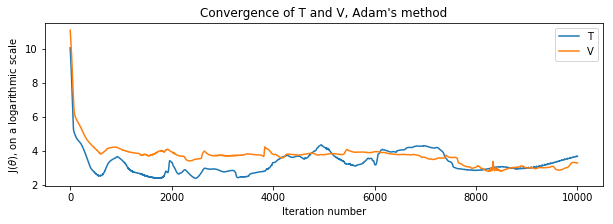

Cost function of T:  39.247830507794156
Cost function of V:  26.39995764957668
Cost function of E:  56.80022761858363


In [188]:
plt.figure(figsize=(10,3))
plt.title("Convergence of T and V, Adam's method")
plt.plot(np.linspace(1,10000,10000),np.log(JlistT),label="T")
plt.plot(np.linspace(1,10000,10000),np.log(JlistV),label="V")
plt.xlabel("Iteration number")
plt.ylabel("J("+str(r'$\theta$')+"), on a logarithmic scale")
plt.legend()
plt.show()

print("Cost function of T: ", J_theta(upsT,T))
print("Cost function of V: ", J_theta(upsV,V))
print("Cost function of E: ", J_theta(upsV+upsT,V+T))

The graph shows how the neural network approximation of T and V converge, where both use the Adam's gradient descent as their optimization function. For this realization, one can see that the value of J($\theta$) oscillates a lot whilst the cost function for V stays primarily stable. The high unstability of T is probably why V ends up with a lower cost function, when the iterations are complete. However, according to the amount of data trained within the training phase (20480 data points) the cost function is actually quite low for the neural network approximation of both T and V.

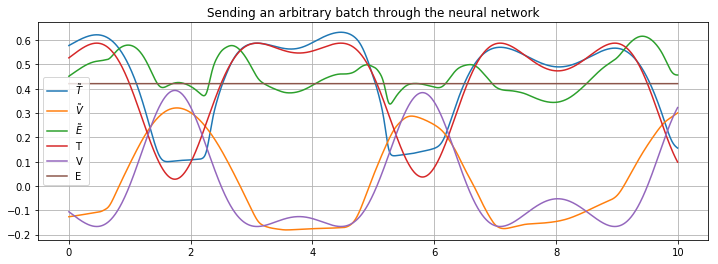

Cost function for T is 1.9516217971422252
Cost function for V is 5.980909381671807
Cost function for the Hamiltonian energy is 6.41692977055861


In [225]:
dill=generate_data(5)


t1 = dill['t']
q1 = dill['Q']
p1 = dill['P']
T1 = dill['T']
V1 = dill['V']

I=np.shape(q1)[1]
d0=np.shape(q1)[0]


upsT1,zkT1 = send_through_network(K,d,I,tau,h,d0,p1,weight_T)


upsV1,zkV1 = send_through_network(K,d,I,tau,h,d0,q1,weight_V)

plt.figure(figsize=(12,4))
plt.title("Sending an arbitrary batch through the neural network")
plt.plot(t1,upsT1,label="$\~T$")
plt.plot(t1,upsV1,label="$\~V$")
plt.plot(t1,upsT1+upsV1,label="$\~E$")
plt.plot(t1,T1,label="T")
plt.plot(t1,V1,label="V")
plt.plot(t1,T1+V1,label="E")
plt.legend()
plt.grid()
plt.show()

print("Cost function for T is",J_theta(upsT1,T1))
print("Cost function for V is",J_theta(upsV1,V1))
print("Cost function for the Hamiltonian energy is",J_theta(upsV1+upsT1,T1+V1))

This gives us a good picture of our neural network approximations of T and V, in comparison to their actual values. We see that $\tilde{T}$ and $\tilde{V}$ follow the same path, though not perfectly, as T and V respectively. Unfortunately, $\tilde{E}$ is not at a set value as a Hamiltonian should be, however we can see that it oscillates around E. The average value of $\tilde{E}$  should thereby be quite close to the actual value of E.

## Computing the gradient <a class="anchor" id="chapter6"></a>

This section is dedicated to computing the gradient based on the output of the network. The algorithms are based on the supplement we were given to the project. 

Let the output of the network be denoted by the function $F: \rm I\!R^d \rightarrow \rm I\!R$. Then $F$ can be seen as a series of $K+1$ functions:

$F(y) = G \circ \phi_{K-1} \circ \phi_{K-2} ... \circ \phi_0 (y)$.

From the supplement we the get that the gradient $\nabla F(y)$ can be computed as a recursive process, and this process can be descrides in pseudocode:

A = gradG(Z^K)

for k in range(K, 0, -1):

    A = gradPhi*A
   
   
where gradG is $\nabla G(y) = \eta'(w^Ty + \mu)w$, and gradPhi*A is $(\nabla \phi_{k-1}(y))^TA = A + W_k^T(h\sigma '(W_ky + b_k) \odot A$. For further details of this computation, see the "Project 2 - supplement". 


There are further comments throughout the code that explains the structure. 

In [29]:
#Sending a point through the network, returning the whole Z_K-matrix
def forward_sweep(Y0, W, b, sigma, h, K):
    ddim,I = Y0.shape
    Z_K = np.zeros((K+1,ddim,I))
    Z_K[0,:,:] = Y0
    for k in range(K):
        Z_K[k+1,:,:] = Z_K[k,:,:] + h*sigma(W[k,:,:] @ Z_K[k,:,:] + b[k,:])
    return Z_K

#computes the gradient for a given point
def gradient(y, W, b, w, mu, h, K, d, d0):
    y_shaped = np.zeros((d, 1))
    y_shaped[0:d0, :] = y
    Z_K = forward_sweep(y_shaped, W, b, sigma, h, K)
    A = w.reshape(-1, 1)
    for k in range(K,0,-1):
        A = A + h*W[k-1,:,:].transpose() @ np.multiply(sigma_derived(W[k-1,:,:]@Z_K[k-1,:,:]+b[k-1,:]),A)
    return A


#here we iterate through a data set, and compute the gradient for each data point individually
def grads_list(theta, h, Y, d, d0):
    W_k, b_k, w, my = theta[0], theta[1], theta[2], theta[3]
    grads = np.zeros((len(Y), d, 1))
    for i in range(len(Y)):
        grads[i] = gradient(Y[i], W_k, b_k, w, my, h, K, d, d0)
    return grads
    

We now make a neural network for the simple function $T(p) = \frac{1}{2}p^2$, which has derivative $T'(p) = p$, to see that the algorithm indeed computes the gradient.

The network is trained with 1000 randomized values between [-2, 2], and then the gradient is computed for 10 equidistributed values between [-1, 1]. 

In [34]:
#Here we test the algorithm for the very simple function T
d = 2
I = 1000
K=30
tau = 0.001
h = 1/30
d0 = 1

y = np.random.uniform(-2, 2, 1000)
c = 1/2*y**2

upsilon, theta,Js = neural_network(K,d,I,tau,h,d0,c,y,adams_method)


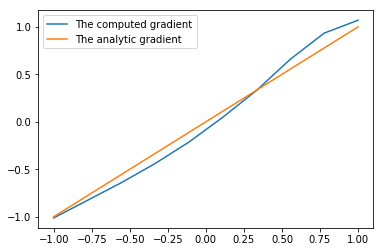

In [35]:
Y = np.linspace(-1, 1, 10)

grads = grads_list(theta, h, Y, d, d0)

plt.plot(Y, grads[:, 0], label="The computed gradient")
plt.plot(Y, Y, label="The analytic gradient")
plt.legend()
plt.show()

Here we see that the algorithm approximates the gradient of the simple function $T$ fairly well, when you consider the relatively small amount of training data that the network was given. We now move on to the numerical integrator methods.


## Symplectic Euler og Størmer-Verlet <a class="anchor" id="chapter7"></a>

### Testing the methods <a class="anchor" id="section_7_1"></a>
The code below implements the symplectic Euler and Størmer-Verlet methods. These two methods help us solve separable Hamiltonian problems. In other words, they can solve systems of differential equations in mechanics by iteration when the gradient is known. The Størmer-Verlet method is a modification of the Euler method.

First we have tested the given examples of Hamiltonian functions, where the functions have been derived by hand. The plots easily show the functions' paths. 

In [36]:
#the given examples of separable Hamiltonian problems in mechanics derived by hand:

def partial_T(p): 
    return p

def partial_V(fnc, q):
    if fnc == fnc_1:#The nonlinear pendulum.
        return np.sin(q)
    if fnc == fnc_2: #Kepler two-body problem.
        return np.array([q[0]/(q[0]**2 + q[1]**2)**(3/2), q[1]/(q[0]**2 + q[1]**2)**(3/2)])
    if fnc == fnc_3: #The Henon-Heiles problem.
        return q + 2*q[0]*q[1] + q[0]**2*q[1]-q[1]
    
def Symplectic_Euler_test(fnc, N, q0, p0, h):
    plist = np.zeros((N, len(p0))) #making a list where we can store the values of q and p later. 
    qlist = np.zeros((N, len(q0)))
    plist[0], qlist[0], p_prev, q_prev = p0, q0, p0, q0 #deciding the initial values for the lists, p and q.
    
    for j in range(1, N):
        q_next = q_prev + h*partial_T(p_prev) #here we have derived T and V for the different functions by hand.
        p_next = p_prev - h*partial_V(fnc, q_next)
        qlist[j] = q_next
        plist[j] = p_next
        p_prev = p_next #setting the value we got as prev so we can use it in the next iteration.
        q_prev = q_next
        
    return qlist, plist

def Størmer_Verlet_test(fnc, N, q, p, del_t):
    plist = np.zeros((N, len(p0)))
    qlist = np.zeros((N, len(q0)))
    plist[0], qlist[0], p_prev, q_prev = p, q, p, q
    
    for i in range(1, N):
        p_half = p_prev - del_t/2 * partial_V(fnc, q_prev)
        q_one = q_prev + del_t * partial_T(p_half)
        p_one = p_half - del_t/2 * partial_V(fnc, q_one)
        
        qlist[i] = q_one
        plist[i] = p_one #not adding p_half in any list, since it is included in p_one.
        p_prev = p_one
        q_prev = q_one

    return qlist, plist 



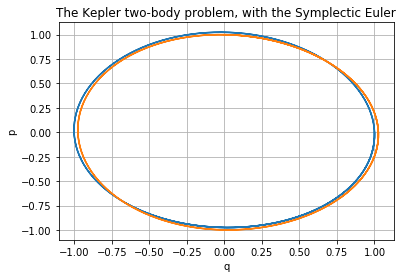

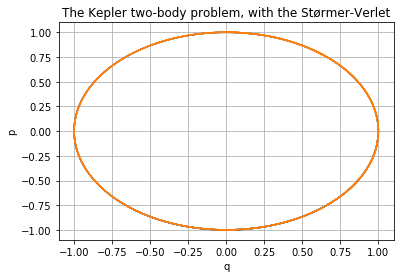

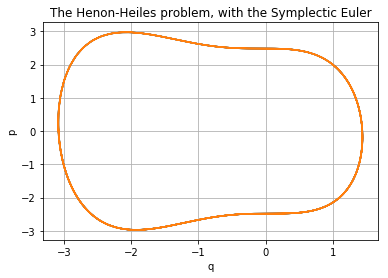

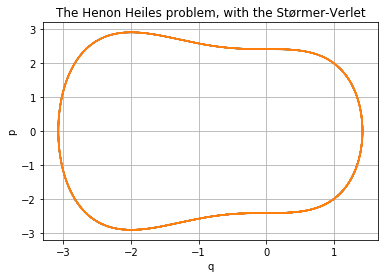

In [94]:
h = 0.05 #step-size
N= 300 #iterations

q0 = np.array([1,0]) #changing these depending on which function and dimension we use.
p0 = np.array([0,1]) #In these cases we set the initial values as what we want. 
qKepSymp, pKepSymp = Symplectic_Euler_test(fnc_2, N, q0, p0, h) #setting p and q as the lists returned, so they have all their different values.
qKepStrom, pKepStrom = Størmer_Verlet_test(fnc_2, N, q0, p0, h)

q0 = np.array([1,1]) 
p0 = np.array([2,2])
qHenSymp, pHenSymp = Symplectic_Euler_test(fnc_3, N, q0, p0, h)
qHenStrom, pHenStrom = Størmer_Verlet_test(fnc_3, N, q0, p0, h)


plt.plot(qKepSymp, pKepSymp)
plt.xlabel('q')
plt.ylabel('p')
plt.title('The Kepler two-body problem, with the Symplectic Euler')
plt.grid()
plt.figure()

plt.plot(qKepStrom, pKepStrom)
plt.xlabel('q')
plt.ylabel('p')
plt.title('The Kepler two-body problem, with the Størmer-Verlet')
plt.grid()
plt.figure()

plt.plot(qHenSymp, pHenSymp)
plt.xlabel('q')
plt.ylabel('p')
plt.title('The Henon-Heiles problem, with the Symplectic Euler')
plt.grid()
plt.figure()

plt.plot(qHenStrom, pHenStrom)
plt.xlabel('q')
plt.ylabel('p')
plt.title('The Henon Heiles problem, with the Størmer-Verlet')
plt.grid()

plt.show()

We now plot the Hamiltonian $H(p, q)$ to see that it is preserved along the paths.

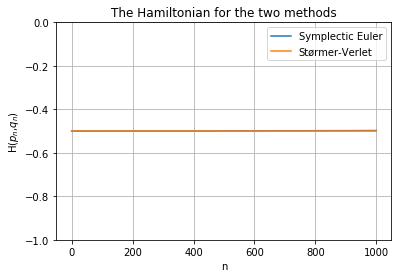

In [104]:
#Plotting the energi function/Hamiltonian of the Kepler two-body

h = 0.0001 #step-size
N= 1000 #iterations

q0 = np.array([1, 0]) #changing these depending on which function and dimension we use.
p0 = np.array([0, 1]) #In these cases we set the initial values as what we want. 

qKepSymp, pKepSymp = Symplectic_Euler_test(fnc_2, N, q0, p0, h) #setting p and q as the lists returned, so they have all their different values.
qKepStorm, pKepStorm = Størmer_Verlet_test(fnc_2, N, q0, p0, h)
VkepSymp = -(1/np.sqrt(qKepSymp[:,0]**2 + qKepSymp[:,1]**2))
VkepStorm = -(1/np.sqrt(qKepStorm[:,0]**2 + qKepStorm[:,1]**2))
TkepSymp = 1/2*(pKepSymp[:, 0]**2 + pKepSymp[:, 1])
TkepStorm = 1/2*(pKepStorm[:, 0]**2 + pKepStorm[:, 1]**2)

plt.title("The Hamiltonian for the two methods")
plt.plot(range(N), VkepSymp + TkepSymp, label="Symplectic Euler")
plt.plot(range(N), VkepStorm + TkepStorm, label="Størmer-Verlet")
plt.xlabel("n")
plt.ylabel("H($p_n$,$q_n$)")
plt.ylim(-1,0)
plt.grid()
plt.legend()
plt.show()


### Numerical methods for the gradient algorithm <a class="anchor" id="section_7_2"></a>

We now implement the numerical methods, Symplectic Euler and Strøm-Verler, to be used along with the gradient computed from the network.

In [81]:
def Symplectic_Euler(N, q0, p0, del_t, h, d0, d, thetaT, thetaV, K): #we take in the theta = W, b, w, mu from each network for T and V
    WT, bT, wT, muT = thetaT[0], thetaT[1], thetaT[2], thetaT[3]
    WV, bV, wV, muV = thetaV[0], thetaV[1], thetaV[2], thetaV[3]
    plist = np.zeros((len(p0), 1, N)) #making a list where we can store the values of q and p later. 
    qlist = np.zeros((len(q0), 1, N))
    plist[:, :, 0], qlist[:, :, 0], p_prev, q_prev = p0, q0, p0, q0 
    
    for j in range(1, N):
        part_T = gradient(p_prev, WT, bT, wT, muT,  h, K, d, d0)[0:d0, :] #computing the gradient at p[j-1]
        q_next = q_prev + del_t*part_T 
        part_V = gradient(q_next, WV, bV, wV, muV,  h, K, d, d0)[0:d0, :] #computing the gradient at q[j]
        p_next = p_prev - del_t*part_V
        qlist[:,:, j] = q_next #setting new values into the list
        plist[:,:, j] = p_next
        p_prev = p_next #setting the value we got as prev so we can use it in the next iteration.
        q_prev = q_next
    
    Vlist, ZV = send_through_network(K,d,N,tau,h,d0,qlist[:, 0, :],thetaV)
    Tlist, ZT = send_through_network(K,d,N,tau,h,d0,plist[:, 0, :],thetaT)
    
    return qlist, plist, Vlist, Tlist

def Størmer_Verlet(N, q0, p0, del_t, h, d0, d, thetaT, thetaV, K): #taking in theta from each network
    WT, bT, wT, muT = thetaT[0], thetaT[1], thetaT[2], thetaT[3]
    WV, bV, wV, muV = thetaV[0], thetaV[1], thetaV[2], thetaV[3]
    plist = np.zeros((len(p0), 1, N)) #making a list where we can store the values of q and p later. 
    qlist = np.zeros((len(q0), 1, N))
    plist[:, :, 0], qlist[:, :, 0], p_prev, q_prev = p0, q0, p0, q0 
    
    for i in range(1, N):
        part_V = gradient(q_prev, WV, bV, wV, muV, h, K, d, d0)[0:d0,:] #computing the gradient at q[i-1]
        p_half = p_prev - del_t/2 * part_V
        part_T = gradient(p_half, WT, bT, wT, muT, h, K, d, d0)[0:d0, :] #computing the gradient at p[i - 1/2]
        q_one = q_prev + del_t * part_T
        part_V = gradient(q_one, WV, bV, wV, muV, h, K, d, d0)[0:d0, :] #computing the gradient at q[i]
        p_one = p_half - del_t/2 * part_V
        
        qlist[:, :, i] = q_one #updating the lists
        plist[:, :, i] = p_one 
        p_prev = p_one #setting the value as prev to use in the next iteration
        q_prev = q_one
        
    Vlist, ZV = send_through_network(K,d,N,tau,h,d0,qlist[:, 0, :],thetaV)
    Tlist, ZT = send_through_network(K,d,N,tau,h,d0,plist[:, 0, :],thetaT)
    
    return qlist, plist, Vlist, Tlist


### Testing the gradient algorithm with the numerical methods <a class="anchor" id="section_7_3"></a>

We now set up a simple network for the Kepler two-body problem, and then test the gradient algorithm for this problem.

In [89]:
#Network for V, q
K = 30
h = 1/30
tau = 0.0001059999
d = 6
d0 = 2
I = 10000

V, q = fnc_4(I)
T, p = fnc_3(I)

upsV, thetaV ,JsV = neural_network(K,d,I,tau,h,d0,V,q,adams_method)
upsT, thetaT ,JsT = neural_network(K,d,I,tau,h,d0,T,p,adams_method)

In [90]:
print(J_theta(upsV,V))
print(J_theta(upsT,T))

627.9129120472467
169.31528271117142


Unfortunately, our cost function was quite high for both $\tilde{V}$ and $\tilde{T}$ in this case. This will affect the numerical methods implemented later on.

In [101]:
del_t = 0.1
N = 1000
d = 6
d0 = 2
K = 30
h = 1/30


q0 = np.zeros((2,1))
q0[:, 0] = np.array([1, 0])
p0 = np.zeros((2, 1))
p0[:, 0]  = np.array([0, 1])

qSymp, pSymp, VSymp, TSymp = Symplectic_Euler(N, q0, p0, del_t, h, d0, d, thetaT, thetaV, K)

qStorm, pStorm, VStorm, TStorm = Størmer_Verlet(N, q0, p0, del_t, h, d0, d, thetaT, thetaV, K)

#Here qSymp and pSymp has shapes (2, 1, 10000), we want them to have shape (10000, 2)



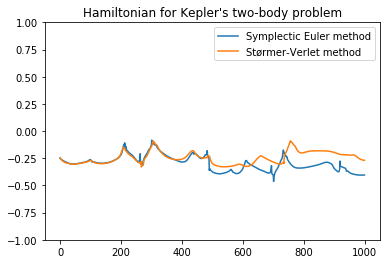

In [102]:
plt.title("Hamiltonian for Kepler's two-body problem")
plt.plot(range(N), VSymp + TSymp, label="Symplectic Euler method")
plt.plot(range(N), VStorm + TStorm, label="Størmer-Verlet method")
plt.xlabel("n")
plt.ylabel("H($p_n,q_n$)")
plt.ylim(-1, 1)
plt.legend()
plt.show()


We see thus that the neural network combined with the algorithm for computing the gradient preserves the Hamiltonian, with some error. If we look at the cost function of (upsV, V) and (upsT, T) we see that this error is explained by the network not approximating $V$ and $T$ well enough. One could minimize this error by using more training data or by given stricter demands to the network, but this is not valuable as we only want to see that that gradient algorithm and the Symplectic Euler/Strørmer-Verlet methods approximates the Hamiltonian reasonably well, and training for larger amount of data or stricter demands is time-costly.


## Approximating the Hamiltonian for unknown trajectories <a class="anchor" id="chapter8"></a>

We now move on to the final part of the project, namely using the neural network, the gradient algorithm and the numerical integrator methods to approximate the Hamiltonian of unknown trajectories.

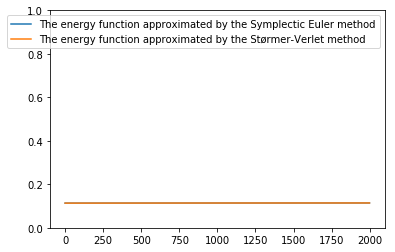

In [100]:
training_data = concatenate(0, 50)
t = training_data['t'][::10]
q = training_data['Q'][:,::10]
p = training_data['P'][:,::10]
T = training_data['T'][::10]
V = training_data['V'][::10]


d0=np.shape(q)[0]
K=30
d=6
h=1/30
tau=0.001059
N = 2000
del_t = 0.001

start_index = np.random.randint(0, 5000)
#start_index=0


q0 = np.zeros((3, 1))
p0 = np.zeros((3, 1))
q0[:, 0] = training_data['Q'][:, start_index]
p0[:, 0] = training_data['P'][:, start_index]


qTrajSymp, pTrajSymp, VTrajSymp, TTrajSymp = Symplectic_Euler(N, q0, p0, del_t, h, d0, d, weight_T, weight_V, K)
qTrajStorm, pTrajStorm, VTrajStorm, TTrajStorm = Størmer_Verlet(N, q0, p0, del_t, h, d0, d, weight_T, weight_V, K)


qSympPlotTraj = np.zeros((N, 3))
pSympPlotTraj = np.zeros((N, 3))
qStormPlotTraj = np.zeros((N, 3))
pStormPlotTraj = np.zeros((N, 3))
for i in range(N):
    qSympPlotTraj[i, :] = qTrajSymp[:, 0, i]
    pSympPlotTraj[i, :] = pTrajSymp[:, 0, i]
    qStormPlotTraj[i, :] = qTrajStorm[:, 0, i]
    pStormPlotTraj[i, :] = pTrajStorm[:, 0, i]
    
    
plt.title("Hamiltonian approximation")
plt.plot(range(N), VTrajSymp + TTrajSymp, label="Symplectic Euler method")
plt.plot(range(N), VTrajStorm + TTrajStorm, label="Størmer-Verlet method")
plt.xlabel("n")
plt.ylabel("H($p_n,q_n$)")
plt.ylim(0,1)
plt.legend()

## Conclusion <a class="anchor" id="chapter9"></a>

Even though we got decent values and output for training the neural network with given functions and then checking them for new random variables, this would not hold for other cases. The network is good for problems in one dimension, but when we have problems of dimension 2 or 3, as we have had in this project, the network is more likely to fail, or to approximate the functions poorly. We see this easily when testing the network on the Kepler two-body problem. 

Despite all this, our general observation is that the neural network does conserve the Hamiltonian property, even though it does not necessarily approximate each data point correctly. This we deduce from plotting the Hamiltonian of the Kepler two-body problem, where despite of the network approximating the functions poorly, the Hamiltonian is relatively preserved. And, for our unknown trajectories, the Hamiltonian was impressively accurate. Hence we have great hope for this network and the belonging methods, and think that with some adjustments it could be a very good approximant for Hamiltonion functions.